<a href="https://colab.research.google.com/github/SimoneCerino/respirazione_cerino/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import torch
import glob
from google.colab import drive

torch.manual_seed(57)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


drive.mount('/content/drive', force_remount=True)

tensors_train = [] # lista di tensor per allenamento
tensors_test = [] # lista di tensor per test
labels_train = [] # lista di etichette relative ai tensor per allenamento
labels_test = [] # lista di etichette relative ai tensor per test
nomi_test = []
len_test = []
at_test = [] # lista di indici at giusti per i file di test
rc_test = [] # lista di indici rc giusti per i file di test
t_t = [] # lista di liste di tensors per test (divisi per file)
l_l = [] # lista di liste contenenti tutte le etichette giuste per i file di test (divisi per file)

window = 32
j = 0
k = 0

folder = '/content/drive/MyDrive/progetto_24/data'
directory = os.fsencode(folder)

# Conto i file nella cartella
file_count = len(glob.glob(f"{folder}/*"))

# Creo an array di lunghezza file_count mettendo 0 se quel file serve per
# l'allenamento e 1 se serve per i test
array = torch.zeros(file_count, dtype=torch.int)
num_ones = int(file_count * 0.2)
print("File di test", num_ones)
indices = torch.randperm(file_count)[:num_ones]
array[indices] = 1

print()
print("""Creo un array di lunghezza file_count mettendo 0 se quel
file serve per l'allenamento e 1 se serve per i test""")
print(array)
print()



for file in os.listdir(directory):
        if array[j] == 1:
            nomi_test.append(os.fsdecode(file))
            t_t.append([])
            l_l.append([])

        file_path = folder + os.sep + os.fsdecode(file)
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names

        # Load each sheet into a DataFrame
        test_df = pd.read_excel(xls, 'Test')
        at_df = pd.read_excel(xls, 'AT')
        rc_df = pd.read_excel(xls, 'RC')
        media_rest_df = pd.read_excel(xls, 'Media Rest')

        print(f"Sto lavorando sul file {file_path}")

        # Remove unit rows and convert columns to appropriate datatypes for normalization
        test_df = test_df.drop([0, 1]).reset_index(drop=True)
        media_rest_df = media_rest_df.drop([0]).reset_index(drop=True)

        # Convert all columns except 't' to numeric
        numeric_cols = test_df.columns.drop('t')
        test_df['t'] = [datetime.combine(datetime.min, t) - datetime.min for t in test_df['t']]
        test_df[numeric_cols] = test_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
        media_rest_df[numeric_cols] = media_rest_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        # Normalize the Test data using Media Rest values
        for col in numeric_cols:
            if media_rest_df.iloc[0][col]:
                test_df[col] /= float(media_rest_df.iloc[0][col])

        if array[j] == 1:
            len_test.append(test_df.shape[0])

        # Extract timestamps from AT and RC and convert them to timedelta
        at_time = datetime.combine(datetime.min, at_df.iloc[1]['t']) - datetime.min
        rc_time = datetime.combine(datetime.min, rc_df.iloc[1]['t']) - datetime.min

        # Convert timestamps to indices in the Test DataFrame
        at_index = np.argmin(np.abs(test_df['t'] - at_time))
        rc_index = np.argmin(np.abs(test_df['t'] - rc_time))

        if array[j] == 1:
            at_test.append(at_index)
            rc_test.append(rc_index)

        # Elimino la colonna dei tempi
        test_df.drop(columns=test_df.columns[0], inplace=True)

        # Ora ciclo su tutto il dataframe
        for i in range(len(test_df)-window+1):
            block = test_df.iloc[i:i+window].values  # Estraggo il blocco 8xwindow come un array NumPy
            tensor = torch.tensor(block, dtype=torch.float32)  # e lo converto in tensor pytorch
            tensor = tensor.flatten()
            tensor.to(device)

            # Se questo file lo stiamo usando come allenamento, metto il tensor in tensors_train, altrimenti in tensors_test
            if array[j] == 0:
                tensors_train.append(tensor)
            else:
                tensors_test.append(tensor)
                t_t[k].append(tensor)
                l_l[k].append([])
                m = 0

            # Decido l'etichetta
            if i<at_index and i+window-1>=rc_index: # a cavallo tra 0 e 2
                if i+(window/2)-1>=rc_index:
                    if array[j] == 0:
                        labels_train.append(2)
                    else:
                        l_l[k][m].append(2)
                        labels_test.append(2)
                else:
                    if array[j] == 0:
                        labels_train.append(0)
                    else:
                        l_l[k][m].append(0)
                        labels_test.append(0)
            if i+window-1<at_index: # prima della prima soglia
                if array[j] == 0:
                    labels_train.append(0)
                else:
                    l_l[k][m].append(0)
                    labels_test.append(0)
            if i<at_index and i+window-1>=at_index and i+window-1<rc_index: # a cavallo tra 0 e 1
                if i+(window/2)-1>=at_index:
                    if array[j] == 0:
                        labels_train.append(1)
                    else:
                        l_l[k][m].append(1)
                        labels_test.append(1)
                else:
                    if array[j] == 0:
                        labels_train.append(0)
                    else:
                        l_l[k][m].append(0)
                        labels_test.append(0)
            if i>=at_index and i+window-1<rc_index: # tra la prima e la seconda soglia
                if array[j] == 0:
                    labels_train.append(1)
                else:
                    l_l[k][m].append(1)
                    labels_test.append(1)
            if i<rc_index and i+window-1>=rc_index and i>=at_index: # a cavallo tra 1 e 2
                if i+(window/2)-1>=rc_index:
                    if array[j] == 0:
                        labels_train.append(2)
                    else:
                        l_l[k][m].append(2)
                        labels_test.append(2)
                else:
                    if array[j] == 0:
                        labels_train.append(1)
                    else:
                        l_l[k][m].append(1)
                        labels_test.append(1)
            if i>=rc_index: # dopo la seconda soglia
                if array[j] == 0:
                    labels_train.append(2)
                else:
                    l_l[k][m].append(2)
                    labels_test.append(2)
            if array[j] == 1:
                m = m+1
        if array[j] == 1:
            k = k+1
        j = j+1


labels_tensor_train = torch.tensor(labels_train, dtype=torch.long)
labels_tensor_test = torch.tensor(labels_test, dtype=torch.long)

print()
print("numero etichette train", len(labels_tensor_train))
print("numero tensor train", len(tensors_train))
print("numero etichette test", len(labels_tensor_test))
print("numero tensor test", len(tensors_test))

Using device: cuda
Mounted at /content/drive
File di test 16

Creo an array di lunghezza file_count mettendo 0 se quel 
file serve per l'allenamento e 1 se serve per i test
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.int32)

Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_79.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_22.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_36.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_05.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_51.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_69.xlsx
Sto lavorando sul file /content/drive/MyDrive/progetto_24/data/Id_62.xlsx
Sto lav

In [ ]:
# Escludo gli outliers con zscore

from scipy import stats

data_tensor = torch.stack(tensors_train)

# Convert tensors to numpy arrays
data_np = data_tensor.numpy()
labels_np = labels_tensor_train.numpy()

# Compute Z-scores for each feature vector
z_scores = np.abs(stats.zscore(data_np, axis=0))

# Define a threshold for outliers
threshold = 3
non_outliers = (z_scores < threshold).all(axis=1)

# Filter out the outliers
filtered_data = data_np[non_outliers]
filtered_labels = labels_np[non_outliers]

# Convert back to tensors
tensors_train = torch.tensor(filtered_data, dtype=torch.float32)
labels_tensor_train = torch.tensor(filtered_labels, dtype=torch.long)

In [ ]:
# Faccio data augmentation sulla classe 1 con SMOTE

from imblearn.over_sampling import SMOTE

class_labels, class_counts = torch.unique(labels_tensor_train, return_counts=True)
train_data_np = tensors_train.cpu().numpy()
train_labels_np = labels_tensor_train.cpu().numpy()

smote = SMOTE(sampling_strategy={1: class_counts[1].item() * 2}, random_state=57) # ne raddoppio il numero
augmented_data_np, augmented_labels_np = smote.fit_resample(train_data_np, train_labels_np)

tensors_train = torch.tensor(augmented_data_np, dtype=torch.float32).to(device)
labels_tensor_train = torch.tensor(augmented_labels_np, dtype=torch.long).to(device)

class_labels, class_counts = torch.unique(labels_tensor_train, return_counts=True)

print("Class Labels:", class_labels)
print("Class Counts:", class_counts)


Class Labels: tensor([0, 1, 2], device='cuda:0')
Class Counts: tensor([ 9000,  9866, 13795], device='cuda:0')


In [ ]:
# Creo dataset e dataloader

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


class CustomTensorDataset(Dataset):
    def __init__(self, tensors, labels):
        self.tensors = tensors
        self.labels = labels

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        tensor = self.tensors[idx]
        label = self.labels[idx]
        return tensor, label


tensors_train = [tensor.to(device) for tensor in tensors_train]
tensors_test = [tensor.to(device) for tensor in tensors_test]

labels_tensor_train.to(device)
labels_tensor_test.to(device)

train_dataset = CustomTensorDataset(tensors_train, labels_tensor_train)
test_dataset = CustomTensorDataset(tensors_test, labels_tensor_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# Definisco e creo il modello

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_size = window*8
hidden_size = 128
num_classes = 3

model = MLP(input_size, hidden_size, num_classes)
model.to(device)

MLP(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08)

In [ ]:
# Alleno il modello

num_epochs = 21

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')


Epoch [1/21], Loss: 0.5886
Epoch [2/21], Loss: 0.4902
Epoch [3/21], Loss: 0.4177
Epoch [4/21], Loss: 0.3913
Epoch [5/21], Loss: 0.3642
Epoch [6/21], Loss: 0.3691
Epoch [7/21], Loss: 0.3546
Epoch [8/21], Loss: 0.3460
Epoch [9/21], Loss: 0.3444
Epoch [10/21], Loss: 0.3356
Epoch [11/21], Loss: 0.3351
Epoch [12/21], Loss: 0.3295
Epoch [13/21], Loss: 0.3332
Epoch [14/21], Loss: 0.3236
Epoch [15/21], Loss: 0.3160
Epoch [16/21], Loss: 0.3157
Epoch [17/21], Loss: 0.3153
Epoch [18/21], Loss: 0.3148
Epoch [19/21], Loss: 0.3105
Epoch [20/21], Loss: 0.3098
Epoch [21/21], Loss: 0.2997


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# folder = '/content/drive/MyDrive/progetto_24/modello57_64.pth'

# torch.save(model.state_dict(), folder)

Accuracy of the model on the test set: 85.80%
Confusion Matrix:
 [[1829  291   16]
 [ 248 1056  251]
 [ 210  232 4655]]


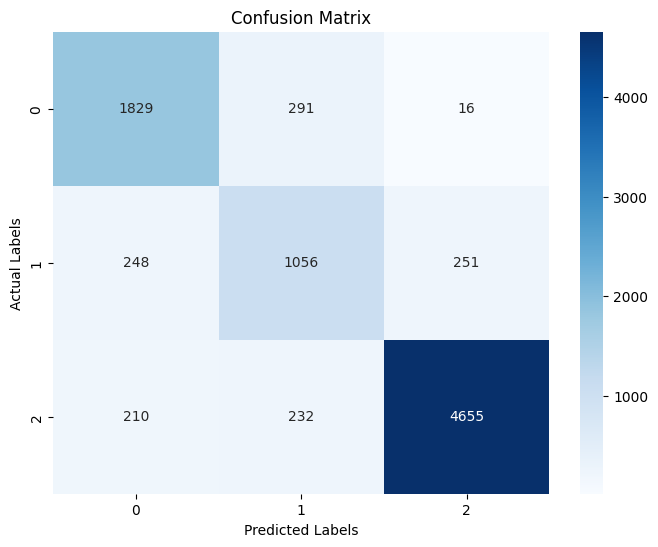

In [ ]:
# Evaluation con accuracy e confusion matrix

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

# Stampo la matrice confusione
print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Precision, recall e f1

from sklearn.metrics import precision_score, recall_score, f1_score

precision_per_class = precision_score(all_labels, all_preds, average=None)
print(f"Precision for each class: {precision_per_class}")

precision_macro = precision_score(all_labels, all_preds, average='macro')
print(f'Macro-averaged Precision: {precision_macro:.2f}')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
print(f'Weighted Precision: {precision_weighted:.2f}')

recall_per_class = recall_score(all_labels, all_preds, average=None)
print(f"Recall for each class: {recall_per_class}")

recall_macro = recall_score(all_labels, all_preds, average='macro')
print(f'Macro-averaged Recall: {recall_macro:.2f}')

recall_weighted = recall_score(all_labels, all_preds, average='weighted')
print(f'Weighted Recall: {recall_weighted:.2f}')

f1_per_class = f1_score(all_labels, all_preds, average=None)
print(f"F1 Score for each class: {f1_per_class}")

f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f'Macro-averaged F1 Score: {f1_macro:.2f}')

f1_weighted = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1_weighted:.2f}')


Precision for each class: [0.79973765 0.66877771 0.94575376]
Macro-averaged Precision: 0.80
Weighted Precision: 0.86
Recall for each class: [0.85627341 0.67909968 0.91328232]
Macro-averaged Recall: 0.82
Weighted Recall: 0.86
F1 Score for each class: [0.82704047 0.67389917 0.92923445]
Macro-averaged F1 Score: 0.81
Weighted F1 Score: 0.86


In [ ]:
model.eval()

# Metto tutte le predicted labels in una lista di liste (variabile pred)

i=0
pred = []

t_t = [[tensor.to(device) for tensor in sublist] for sublist in t_t]

with torch.no_grad():
    for lista in t_t:
        pred.append([])
        for tensor in lista:
            tensor = tensor.unsqueeze(0)
            outputs = model(tensor)
            _, predicted = torch.max(outputs.data, 1)

            pred[i].append(predicted.item())
        pred[i] = torch.from_numpy(np.array(pred[i]))
        i = i+1

In [ ]:
# in pred ho tutte le sequenze di label predette
# in at_test ho gli indici at predetti
# in rc_test ho gli indici rc predetti
# in nomi_test ho i nomi
# in len_test ho le lunghezze di ciascun file

In [ ]:
# Funzione per contare gli zeri in un tensor da un dato indice a un altro
def count_zeros(tensor, start_index, end_index):

    if len(tensor.shape) != 1:
        raise ValueError("The input tensor must be a 1D tensor.")

    if start_index < 0 or end_index >= len(tensor) or start_index > end_index:
        raise IndexError("Start or end index is out of the tensor bounds or invalid.")

    sliced_tensor = tensor[start_index:end_index + 1]

    zero_count = torch.sum(sliced_tensor == 0).item()

    return zero_count


# Funzione per contare i due in un tensor da un dato indice a un altro
def count_twos(tensor, start_idx, end_idx):
    dim = 0

    if start_idx < 0 or end_idx > tensor.size(dim):
        raise ValueError("Start or end index out of bounds for the specified dimension.")

    slices = [slice(None)] * tensor.dim()
    slices[dim] = slice(start_idx, end_idx)

    sub_tensor = tensor[tuple(slices)]

    count = torch.sum(sub_tensor == 2).item()

    return count

# Funzione per trovare la soglia AT dato un tensor di targhette predette
def trova_at(tensor, shift):
    if len(tensor.shape) != 1:
        raise ValueError("The input tensor must be a 1D tensor.")

    tensor_length = len(tensor)

    for j in range(40, 0, -1):
        for i in range(tensor_length - j-1):
            if tensor[i] == 1 or tensor[i] == 2:
                if count_zeros(tensor,i+1,i+1+j) <= 5:
                    return i + shift


    # Se non lo trovo, do errore
    raise ValueError("Not found at")


# Funzione per trovare la soglia RC dato un tensor di targhette predette
def trova_rc(tensor, shift):
    if len(tensor.shape) != 1:
        raise ValueError("The input tensor must be a 1D tensor.")

    tensor_length = len(tensor)
    for j in range(40, 0, -1):
        for i in range(tensor_length - j-1):
            if tensor[i] == 2:
                if count_twos(tensor,i+1,i+j+1) >= j-4:
                    return i + shift

    # Se non lo trovo, do errore
    raise ValueError("Not found rc")

In [ ]:
for i in range(num_ones):
    shift = int(window/2)-1
    print(i+1)
    l_l[i][0] = torch.from_numpy(np.array(l_l[i][0]))
    h = pred[i]
    p = l_l[i][0]
    p[at_test[i]-int(window/2)+1] += 10
    p[rc_test[i]-int(window/2)+1] += 10

    print("file:",nomi_test[i])
    print("lunghezza file",len_test[i])
    print()
    print("indice at predetto:",trova_at(pred[i], shift))
    print("indice at giusto:",at_test[i])
    print("errore at:", abs(trova_at(pred[i], shift)-at_test[i]))
    print()
    print("indice rc predetto:",trova_rc(pred[i], shift))
    print("indice at giusto:",rc_test[i])
    print("errore rc:", abs(trova_rc(pred[i], shift)-rc_test[i]))

    print()
    print("Etichette predette:")
    print(h)

    print()
    print("Etichette giuste: (i cambiamenti di soglia sono indicati con +10)")
    print(p)
    print()

1
file: Id_69.xlsx
lunghezza file 936

indice at predetto: 158
indice at giusto: 221
errore at: 63

indice rc predetto: 237
indice at giusto: 294
errore rc: 57

Etichette predette:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2,

In [ ]:
# Calcolo la media di quanto sono sbagliati in valore assoluto i valori predetti di AT e RC

cumu_at = 0

for i in range(num_ones):
    shift = int(window/2)-1
    fuori = abs(at_test[i]-trova_at(pred[i], shift))
    cumu_at += fuori

print("media sbaglio at", cumu_at/num_ones)

cumu_rc = 0

for i in range(num_ones):
    shift = int(window/2)-1
    fuori = abs(rc_test[i]-trova_rc(pred[i], shift))
    cumu_rc += fuori

print("media sbaglio rc", cumu_rc/num_ones)

media sbaglio at 31.625
media sbaglio rc 30.625
